## Simulating Diffraction from Glasses 

Here is a simple explination of how to simulate diffraction from MD modelsing of metallic glasses. This is a smallish ZrCu metallic glass that was melted and quenched at 2E12 K/s.

We will look at the model using 


`hyperspy` https://hyperspy.org/index.html
`abtem` https://abtem.github.io/doc/intro.html
`ase` https://wiki.fysik.dtu.dk/ase/

And then all of the compuations use 
`dask` https://www.dask.org

Carter Francis| csfrancis@wisc.edu | 2023-09-22

In [1]:
import abtem
import ase
import matplotlib.pyplot as plt
import hyperspy.api as hs
import hyperspy 

print(ase.__version__)
print(abtem.__version__)
print(hyperspy.__version__)

3.22.1
1.0.0beta22
2.0.dev0


## Load the Trajectory

First we can load the lammps traj into ase.  We are looking at a smallish ZrCu system that was melted and then quenched using lammps.

This isn't a great simulation but should be fine for this demo. 

In [2]:
atoms = ase.io.read("data/traj.lammpstrj")

We need to change the atomic numbers here so that they are Zr Cu

In [3]:
num = atoms.get_atomic_numbers()
num[num==1]=29 # Cu
num[num==2]=40 # Zr

In [4]:
atoms.set_atomic_numbers(num)

In [5]:
atoms # ase object

Atoms(symbols='Cu1976Zr3512', pbc=True, cell=[44.2988130172251, 44.2988130172251, 44.2988130172251])

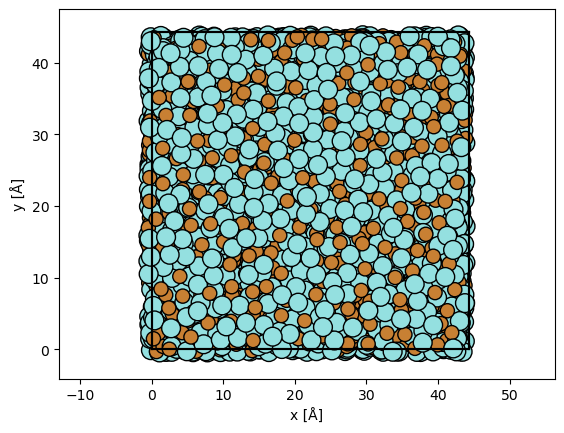

In [6]:
fig, ax = abtem.show_atoms(atoms) # abtem has a nice plotting feature so we use this to show the atoms

## Tiling the simulation

In order to get higher resolution in the reciporical sampling we need to increase the size of the simulation in real space.  We can just add vacuum to the sample or we can tile the sample.  In most cases tiling the data is the better thing to do (and is how the simulation was created as well :)


In [7]:
atoms_tiled = atoms *(3,3,1)

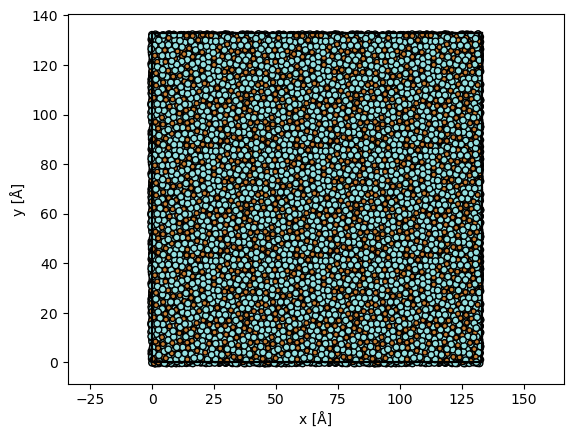

In [8]:
fig, ax = abtem.show_atoms(atoms_tiled)

## MultiSlice Simulations 

To preform a 4-D STEM multislice simulation you need a couple of different objects

1. `abtem.Atoms` or `abtem.FrozenPhonons` object describing the positions of the atoms
2. `abtem.Potential` object which describes the potential for each slice in the data
3. `abtem.Probe` the Probe which is convolved with the potential at each slice as it propogates through the material
4. `abtem.GridScan` the positions on the smaple at which you are sampling in real space
5. `abtem.PixelatedDetector` The pixelated dector which is what is used to aquire the resulting data. 

## 1. Atoms and FrozenPhonons

Here you can see that the atoms are slightly displaced after adding in the phonon vibrations.  Because the electrons travel much faster than the lattice vibrations the electrons sample "snapshots" of atomic positions.  We can simulate this by repeating the simulation with multiple frozen phonons and then averaging over these frozen phonons. 

In [9]:
frozen_phonons = abtem.FrozenPhonons(atoms, # origional atoms 
                                     num_configs=2, # number of frozen phonons
                                     sigmas=0.1, # This should be something like the phonon virbration for Cu and Zr.  0.1 is a good estimation though
                                     seed=100) 

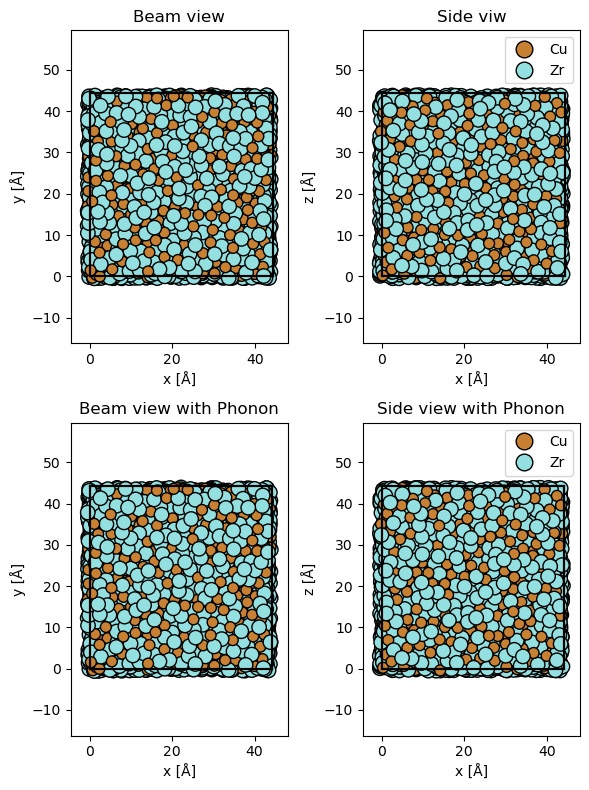

In [10]:
atoms_configuration = next(iter(frozen_phonons))

fig, ax = plt.subplots(2, 2, figsize=(6, 8))
abtem.show_atoms(atoms, scale=1, ax=ax[0,0], title="Beam view")
abtem.show_atoms(
    atoms,
    scale=1,
    plane="xz",
    legend=True,
    ax=ax[0,1],
    title="Side viw",);

abtem.show_atoms(atoms_configuration, scale=1, ax=ax[1,0], title="Beam view with Phonon")
abtem.show_atoms(
    atoms_configuration,
    scale=1,
    plane="xz",
    legend=True,
    ax=ax[1,1],
    title="Side view with Phonon",);
fig.tight_layout()

## 2. Building a Potential

The potential can either be built from a set of FrozenPhonons or a Atoms object

In [11]:
potential = abtem.Potential(frozen_phonons,
                            slice_thickness=0.5, # about 1 atom in thick
                            sampling=0.05)  #  replace atoms with frozen_phonon to get multiple simulations (5-D data fp,rx,ry,kx,ky)


potential = abtem.Potential(atoms,
                            slice_thickness=0.5, # about 1 atom in thick
                            sampling=0.05)  #  replace atoms with frozen_phonon to get multiple simulations (5-D data fp,rx,ry,kx,ky)

In [12]:
potential = abtem.Potential(atoms,
                            slice_thickness=0.5, # about 1 atom in thick
                            sampling=0.05 # real space sampling  
                           )
display(potential.build().array) # lazy potential array of 89 slices (from a total thickness of around 4.5 nm)


potential_array = potential.build()
potential_array.compute() # this might take a bit

dask.array<_wrap_build_potential, shape=(89, 886, 886), dtype=float32, chunksize=(89, 886, 886), chunktype=numpy.ndarray>

[########################################] | 100% Completed | 19.29 s


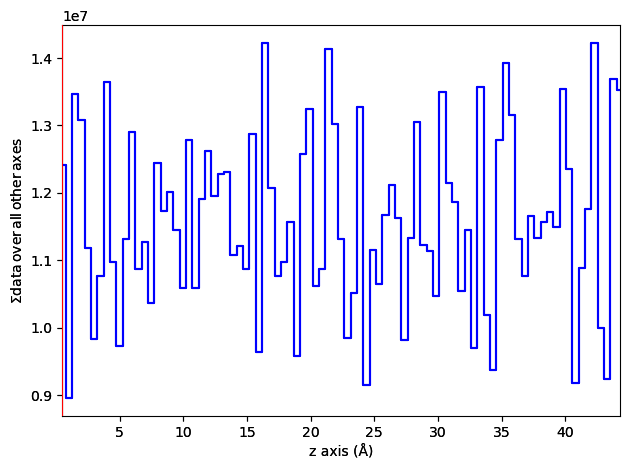

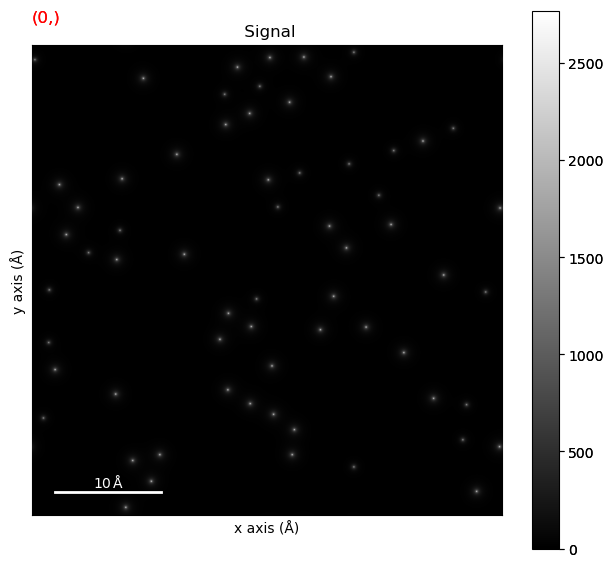

In [13]:
potential_array.to_hyperspy().plot() # plot the different potentials for each slice.  We can step through each slice and basicallt see the atoms at each slice through the thickness.

## 3. Building a Probe

The probe describes the electron beam that rasters over the sample.

In [14]:
# 200 keV and a semiangle of 1.5 mrad gives a probe size of ~1 nm 
# Should probably use 0.7 mrad for a probe size of ~0.5 nm
probe = abtem.Probe(energy=200e3, 
                    semiangle_cutoff=1.5)
probe.grid

Here we can see why the size of the simulation is important.  Just looking at the size of the zero beam vs the extent of the simulation for a convergance angle of 2.5

[########################################] | 100% Completed | 112.84 ms
[########################################] | 100% Completed | 210.03 ms
[########################################] | 100% Completed | 529.24 ms
[########################################] | 100% Completed | 836.54 ms
[########################################] | 100% Completed | 2.51 ss


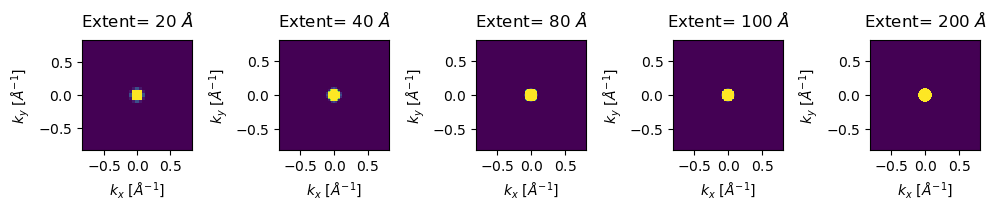

In [15]:
fig, axs = plt.subplots(1,5, figsize=(10,5))
for i, extent in enumerate([20,40,80, 100,200]):
    probe = abtem.Probe(energy=200e3, 
                    semiangle_cutoff=2.5,
                       sampling=0.05,
                        extent=extent,
                       )
    diffraction_patterns = probe.build().diffraction_patterns(max_angle=20)

    visualization = diffraction_patterns.show(title= f"Extent= {extent} $\AA$",ax=axs[i])
fig.tight_layout()

We can also see the size of the probe in real space

[########################################] | 100% Completed | 104.29 ms
[########################################] | 100% Completed | 106.38 ms
Size of the Probe in Real Space 2.5 mrad= 4.82 Å
[########################################] | 100% Completed | 102.20 ms
[########################################] | 100% Completed | 101.97 ms
Size of the Probe in Real Space 1.5 mrad = 6.32 Å


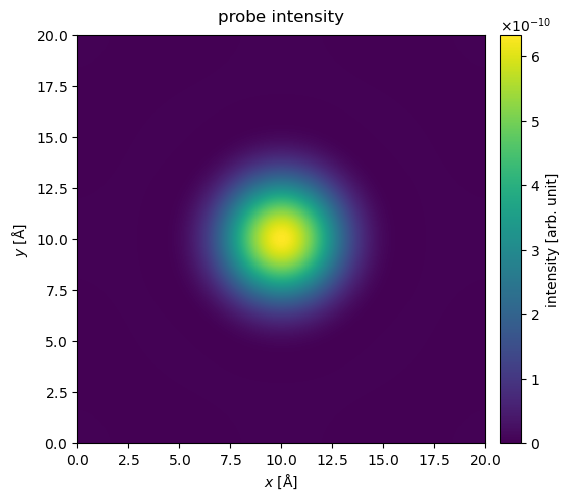

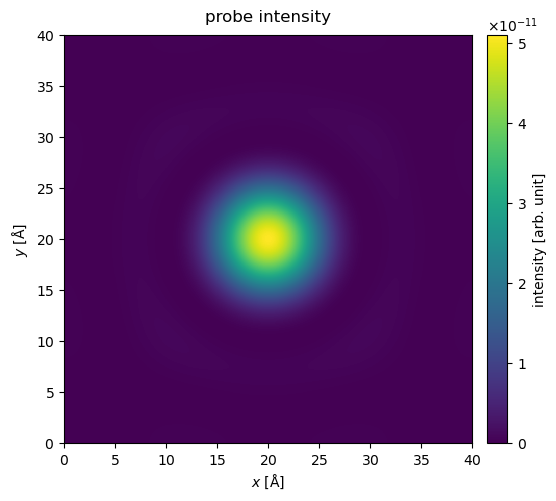

In [16]:
# 200 keV and a semiangle of 1.5 mrad gives a probe size of ~1 nm 
# Should probably use 0.7 mrad for a probe size of ~0.5 nm
probe = abtem.Probe(energy=200e3, 
                    semiangle_cutoff=2.5,
                       sampling=0.05,extent=20,)
probe.build().compute()

intensity = probe.build().intensity().compute()

visualization = intensity.show(cbar=True)
visualization.set_column_titles("probe intensity", fontsize=12)


lineprofile = intensity.interpolate_line_at_position(
    center=(10, 10), angle=0, extent=10
)

fwhm = lineprofile.width(height=0.5)

print(f"Size of the Probe in Real Space 2.5 mrad= {fwhm.item():.2f} Å")


probe = abtem.Probe(energy=200e3, 
                    semiangle_cutoff=1.5,
                    sampling=0.05, # real space sampling
                    extent=40, # size of the simulation
                   )
probe.build().compute()

intensity = probe.build().intensity().compute()

visualization = intensity.show(cbar=True)
visualization.set_column_titles("probe intensity", fontsize=12)


lineprofile = intensity.interpolate_line_at_position(
    center=(10, 10), angle=0, extent=20
)

fwhm = lineprofile.width(height=0.5)

print(f"Size of the Probe in Real Space 1.5 mrad = {fwhm.item():.2f} Å")

In [17]:
lineprofile

# 4. Building a Grid to Scan

In abTEM you can easily create a grid using the GridScan functionality. 

In [18]:
scan = abtem.GridScan(start=(5,5), end=(40,40), gpts=5) # 25 positions.

In [19]:
def add_probe_positions_to_image(scan, ax, size=1000):
    pos = scan.get_positions()
    pos = pos.reshape((-1,2))
    ax.scatter(pos[:,0],pos[:,1], s=size ,c="none", linewidths=1, edgecolors="w" )

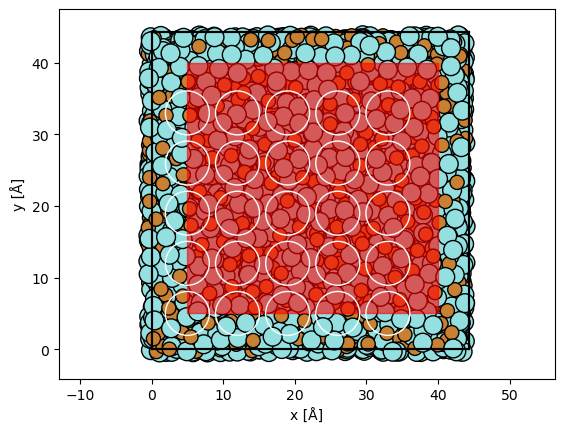

In [20]:
fig, ax = abtem.show_atoms(atoms)
scan.add_to_plot(ax, alpha=0.6)
add_probe_positions_to_image(scan, ax) # i think the sctter positions are the actual positions. As for the size 

## 5. Creating a Pixelated Detector

You can create a pixelated detector using the `abtem.PixelatedDetector` class.  Setting a max angle is usually a good idea for glasses otherwise you end up with lots of things you don't care about. 

In [21]:
import numpy as np

max_angle = 30 # mrad
detector = abtem.PixelatedDetector(max_angle=30) # set the max angle to 30 so we don't have a bunch of extra pixels 

# for 200 kev the conversion to inverse nm is 
def get_wavelength(acc_volt=200E3):
    """Get wavelength in nm"""
    wavelength = 1.23/np.sqrt(acc_volt*((1+9.78E-7*acc_volt)))
    return wavelength

max_k_inverse_nm = np.tan(max_angle*10**-3)*(1/get_wavelength()) 
print("Max k:" , max_k_inverse_nm,  "nm^-1")

Max k: 11.930383659229996 nm^-1


## And Then to Compute

In [22]:
measurements = probe.scan(potential,
                           scan=scan,
                           detectors=detector)
measurements.compute() # use dask to compute the 25 different positions. 

[########################################] | 100% Completed | 204.14 s


# Convert it to hyperspy signal

I like to do this it helps to save the data in a way that is pretty easy to acess later using the zarr backend.

In [23]:
signal = measurements.to_hyperspy()

In [24]:
%matplotlib ipympl
signal.plot(vmax="99th") # vmax = 99th to set a threshold or else the zero beam will dominate

## Another Thing

You can just directly pass the dask object without computing to hyperspy and then you can save using the `zarr` backend which is pretty performative and works well with distributed computing. 

In [ ]:
measurements = probe.scan(potential,
                          scan=scan,
                          detectors=detector)
#measurements.compute() # don't compute it
signal = measurements.to_hyperspy() # Now the signal is lazy


signal.save("ZrCuVeiw[100].zspy") # compute and then save.  This is the most memory efficient way!

In [ ]:
s = hs.load("ZrCuVeiw[100].zspy") # Load up the simulation